In [1]:
import math
import pandas as pd

from sklearn import metrics, preprocessing, cluster

from scipy.spatial import distance
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

In [2]:
# Read file
icfes = pd.read_csv("./data/ICFES/icfes_preprocessing.csv", low_memory=False, encoding="utf-8")

print(icfes.shape)

icfes.describe()

(554679, 68)


,DESEMP_C_NATURALES,DESEMP_LECTURA_CRITICA,DESEMP_MATEMATICAS,DESEMP_SOCIALES_CIUDADANAS,ESTU_INSE_INDIVIDUAL,ESTU_NSE_ESTABLECIMIENTO,PERCENTIL_C_NATURALES,PERCENTIL_GLOBAL,PERCENTIL_INGLES,PERCENTIL_LECTURA_CRITICA,PERCENTIL_MATEMATICAS,PERCENTIL_SOCIALES_CIUDADANAS,PERIODO,PUNT_C_NATURALES,PUNT_GLOBAL,PUNT_INGLES,PUNT_LECTURA_CRITICA,PUNT_MATEMATICAS,PUNT_SOCIALES_CIUDADANAS
count,554679.000000,554679.000000,554679.000000,554679.000000,551893.000000,553993.000000,554679.000000,554679.000000,554679.000000,554679.000000,554679.000000,554679.000000,554679.000000,554679.000000,554679.000000,554679.000000,554679.000000,554679.000000,554679.000000
mean,2.231510,2.695186,2.424215,2.172224,50.639441,2.365806,50.652603,50.498465,50.648169,50.574576,50.599347,50.603268,20171.976785,51.532825,256.819117,50.032262,53.434341,50.394147,50.537165
std,0.736064,0.712229,0.763448,0.793816,9.308649,0.719504,28.838822,28.858438,28.829744,28.876041,28.862893,28.846366,0.150587,10.186885,49.282731,11.984361,9.876249,12.143610,11.254386
min,1.000000,1.000000,1.000000,1.000000,14.413616,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20171.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,44.156093,2.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,20172.000000,44.000000,219.000000,41.000000,46.000000,41.000000,42.000000
50%,2.000000,3.000000,2.000000,2.000000,50.067828,2.000000,51.000000,50.000000,51.000000,51.000000,51.000000,51.000000,20172.000000,51.000000,254.000000,48.000000,53.000000,50.000000,50.000000
75%,3.000000,3.000000,3.000000,3.000000,56.237077,3.000000,76.000000,75.000000,76.000000,76.000000,76.000000,76.000000,20172.000000,59.000000,291.000000,57.000000,60.000000,59.000000,58.000000
max,4.000000,4.000000,4.000000,4.000000,84.394966,4.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,20172.000000,100.000000,476.000000,100.000000,100.000000,100.000000,100.000000


In [3]:
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes

columns = ['COLE_AREA_UBICACION', 'COLE_BILINGUE']

columns = [
    'FAMI_COMECARNEPESCADOHUEVO', 
    'FAMI_COMECEREALFRUTOSLEGUMBRE', 
    'FAMI_COMELECHEDERIVADOS', 
    'FAMI_CUARTOSHOGAR', 
    'FAMI_EDUCACIONMADRE', 
    'FAMI_EDUCACIONPADRE', 
    'FAMI_ESTRATOVIVIENDA', 
    'FAMI_NUMLIBROS', 
    'FAMI_PERSONASHOGAR', 
    'FAMI_SITUACIONECONOMICA', 
    'FAMI_TIENEAUTOMOVIL', 
    'FAMI_TIENECOMPUTADOR', 
    'FAMI_TIENECONSOLAVIDEOJUEGOS', 
    'FAMI_TIENEHORNOMICROOGAS', 
    'FAMI_TIENELAVADORA', 
    'FAMI_TIENEMOTOCICLETA', 
    'FAMI_TIENESERVICIOTV', 
    'FAMI_TRABAJOLABORMADRE', 
    'FAMI_TRABAJOLABORPADRE',
    'DESEMP_INGLES', 
    #'DESEMP_C_NATURALES', 
    #'DESEMP_INGLES', 
    #'DESEMP_LECTURA_CRITICA', 
    #'DESEMP_MATEMATICAS',
    #'DESEMP_SOCIALES_CIUDADANAS'
]

dataset = icfes[columns]

subset = dataset.loc[dataset['DESEMP_INGLES'].isin(["B+"])]

print("dataset", dataset.shape, "subset", subset.shape)

# Nominal to binary
dummies = pd.get_dummies(subset)

dummies.to_csv("./data/ICFES/icfes_pre_clustering.csv", index=False, encoding="utf-8")

rows = math.ceil(dummies.shape[0]*1.0)

X = dummies.values[:rows, :]

print("X", X.shape)

dataset (554679, 20) subset (13550, 20)
X (13550, 125)


In [11]:
import time

start_time = time.time()

#distance_matrix = gower_distance_matrix2(X)

print("--- {0} seconds ---".format(time.time() - start_time))

#distance_matrix

--- 2.7418136596679688e-05 seconds ---


# K-modes

For n_clusters = 2 The average silhouette_score is : 0.33404445195106847
For n_clusters = 3 The average silhouette_score is : 0.27722626330047395
For n_clusters = 4 The average silhouette_score is : 0.17374615944048064
For n_clusters = 5 The average silhouette_score is : 0.1761395689597226


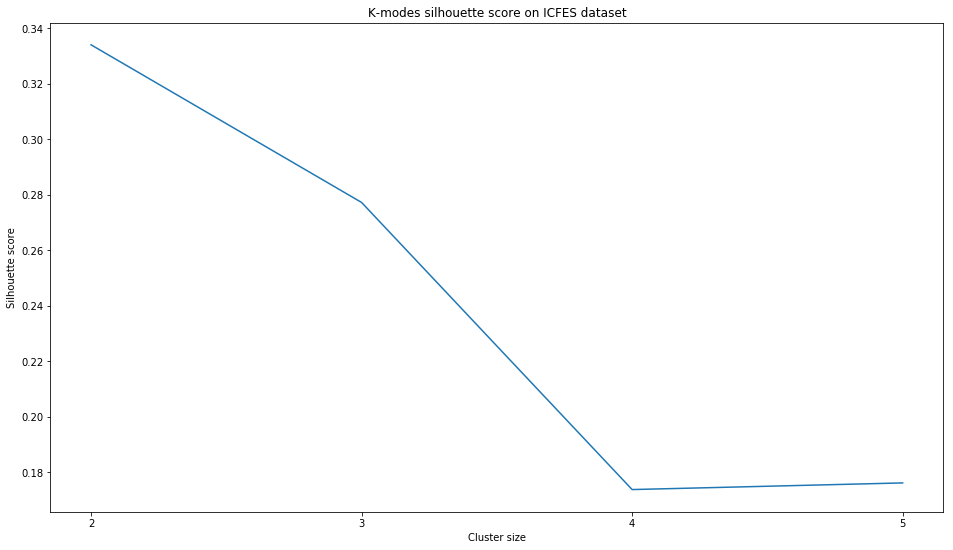

In [5]:
def plot_silhouette_score(X, range_n_clusters, attribute_names):
    
    C = len(range_n_clusters)
    
    silhouette_avg = []
    clusterers = []
    
    for n_clusters in range_n_clusters:
        
        # Initialize the clusterer with n_clusters value.
        clusterer =  KModes(n_clusters=n_clusters, init='Cao', n_init=5)
        cluster_labels = clusterer.fit_predict(X)
        clusterers.append(clusterer)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        current_silhouette_avg = metrics.silhouette_score(X, cluster_labels, metric='hamming', n_jobs=-1)
        print("For n_clusters =", n_clusters, "The average silhouette_score is :", current_silhouette_avg)
        silhouette_avg.append(current_silhouette_avg)
    
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 9))
    ax1.plot(range_n_clusters, silhouette_avg)
    ax1.set_xticks(range_n_clusters)
    ax1.set_title("K-modes silhouette score on ICFES dataset")
    ax1.set_xlabel("Cluster size")
    ax1.set_ylabel("Silhouette score")
    
    plt.show()
    
    return clusterers, silhouette_avg

range_n_clusters = range(2, 6)

clusterers, silhouette_avg = plot_silhouette_score(X, range_n_clusters, dummies.columns)

For n_clusters = 2 The average silhouette_score is : 0.33404445195106847


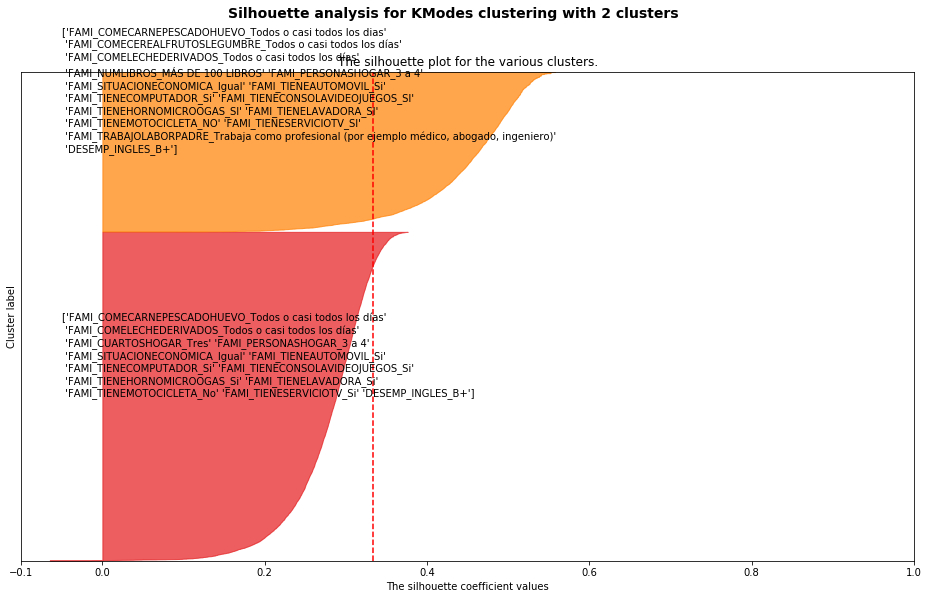

In [6]:
def plot_silhouette(X, clusterer, attribute_names, metric='hamming'):
    
    cluster_labels = clusterer.predict(X)
    n_clusters = clusterer.n_clusters

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = metrics.silhouette_score(X, cluster_labels, metric=metric, n_jobs=-1)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels, metric=metric, n_jobs=-1)
    
    # Create a subplot with 1 row and 1 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(16, 9)

    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.Set1(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        label_idx = np.array(clusterer.cluster_centroids_[i], dtype=bool)
        label_atributes = np.array(attribute_names)
        label = label_atributes[label_idx]
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(label))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KModes clustering "
                      "with {0} clusters".format(n_clusters)),fontsize=14, fontweight='bold')
    
    plt.show()
    

best_clusterer = clusterers[np.argmax(silhouette_avg)]
plot_silhouette(X, best_clusterer, dummies.columns)

# Hierarchical

In [7]:
from scipy.cluster import hierarchy    

labels = dummies.columns

methods = {'single', 'complete', 'average'}

def hierarchical_exp(X, methods):
    
    Z = []
    
    for method in methods:
        # generate the linkage matrix
        Z.append(hierarchy.linkage(X, method=method, metric='hamming'))

    return Z
    
Z = hierarchical_exp(X, methods)

In [8]:
def plot_hierarchical(Z, methods):
    r, c = (2, 2)
    fig, axes = plt.subplots(r, c, figsize=(16, 9*r))
    plot_num = 1

    for z, method in zip(Z, methods):
        # plot
        ax = plt.subplot(r, c, plot_num)
        dn = hierarchy.dendrogram(z, orientation='right', p=3, truncate_mode='level', count_sort='ascending')
        ax.set_title("hierarchical clustering ("+method+")")
        plot_num +=1

    plt.tight_layout()
    plt.show()
    
#plot_hierarchical(Z, methods)

# DBSCAN

In [9]:
def dbscan_experiment(X):

    epsilons = np.linspace(0.01, 0.5, num=20)
    n_clusters = []
    clusterers = []
    
    for eps in epsilons:
        db = cluster.DBSCAN(eps=eps, min_samples=4, metric='hamming', n_jobs=-1).fit(X)
        labels = db.labels_
        clusterers.append(db)

        # Number of clusters in labels, ignoring noise if present.
        n_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))
    
    return clusterers, n_clusters

clusterers, n_clusters = dbscan_experiment(X)

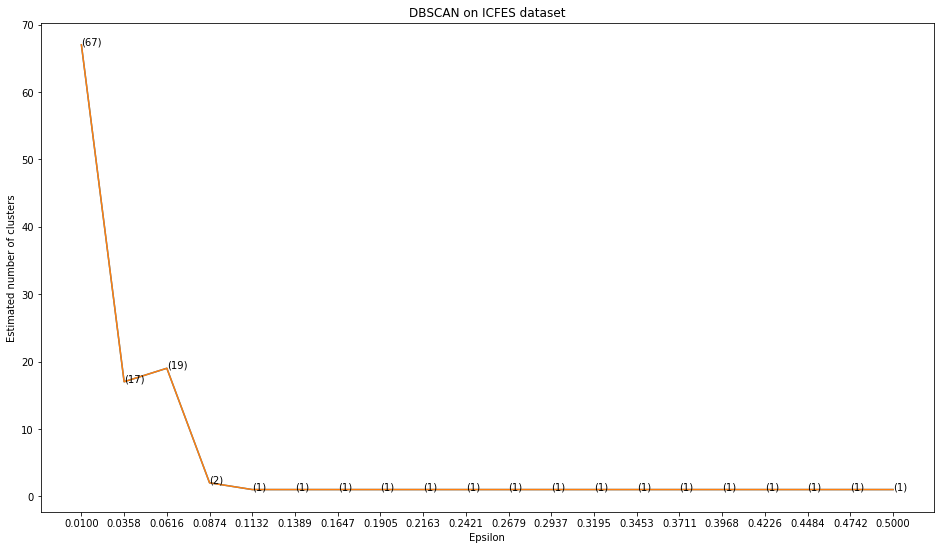

In [10]:
def plot_dbscan_experiment(clusterers, n_clusters):
    
    epsilons = [db.eps for db in clusterers]
    
    # Plot result
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))

    ax.plot(epsilons, n_clusters)
    
    ax.set_xticks(epsilons)
    
    # Annotate coordinates
    plt.plot(epsilons, n_clusters)
    for xy in zip(epsilons, n_clusters):
        ax.annotate("({0})".format(xy[1]), xy=xy, textcoords='data')
    
    ax.set_title("DBSCAN on ICFES dataset")
    ax.set_xlabel("Epsilon")
    ax.set_ylabel("Estimated number of clusters")
    
    plt.show()
    
#############

plot_dbscan_experiment(clusterers, n_clusters)